In [1]:
import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading

single_dataset, test_dataset = data_loading.get_val_dataset(
    # 'DT4D_inter_pair',
    'DT4D_intra_pair',
    'test', 200, preload=False, return_evecs=True, centering='bbox'
    )

In [3]:
with open('/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/'
          # 'single_64_2-2ev_64-128-128_remeshed/eval/epoch_99/SHREC19_r_pair-test/taubin-5/log_taubin-5.txt'
        # '/single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/no_smoothing/log_no_smoothing.txt'
        '/single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/no_smoothing/log_no_smoothing.txt'
        
        # 'single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/laplacian-5/log_laplacian-5.txt'
        
        # '/single_template_remeshed/eval/checkpoint_99.pt/DT4D_inter_pair-test/fill_holes-0/log_fill_holes-0.txt'
        # '/single_template_remeshed/eval/checkpoint_99.pt/DT4D_intra_pair-test/fill_holes-0/log_fill_holes-0.txt'
        # '/single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/DT4D_intra_pair-test/no_smoothing/log_no_smoothing.txt'
        , 'r') as f:
  
    lines = f.readlines()
len(lines)

# try with smoothing

In [4]:
pairzo_errs = []

search_str = 'Geo error est pairzo mean: '

example_str = 'Geo error est pairzo mean: 2.233'

for line in lines:
    if 'Geo error est pairzo mean: ' in line:
        pairzo_errs.append(float(line.split(search_str)[1].strip()))
        
len(pairzo_errs)

In [5]:
shape_ids_first = []
shape_ids_second = []

# for corr_file in test_dataset.corr_files:
    # 'data/SHREC19_r/corres/12_1.map'
    # id_1 = int(corr_file.split('/')[-1].split('_')[0]) - 1
    # id_2 = int(corr_file.split('/')[-1].split('_')[1].split('.')[0]) - 1
    
    # shape_ids_first.append(id_1)
    # shape_ids_second.append(id_2)
    
for combination in test_dataset.combinations:
    shape_ids_first.append(combination[0])
    shape_ids_second.append(combination[1])

In [6]:
import torch

# set to 0, for each unique shape id

unique_shapes = set(shape_ids_first)

errs_by_shape = torch.zeros(len(single_dataset))
times_by_shape = torch.zeros(len(single_dataset))

for i in range(len(shape_ids_first)):
    # print(i)
    errs_by_shape[shape_ids_first[i]] += pairzo_errs[i]
    errs_by_shape[shape_ids_second[i]] += pairzo_errs[i]
    
    times_by_shape[shape_ids_first[i]] += 1
    times_by_shape[shape_ids_second[i]] += 1
    
errs_by_shape /= times_by_shape    


In [7]:
times_by_shape

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(errs_by_shape.numpy())
axs[1].hist(errs_by_shape.numpy(), bins=50)

# plt.label('Errors by shape, no smoothing')
# make a title above all subplots
fig.suptitle('Errors by shape, taubin-5')

plt.show()

In [9]:
sorted_errs, sorted_ids = torch.sort(errs_by_shape, descending=True)

print(sorted_errs)
print(sorted_ids)

# get the 10 worst shapes, without nans 
worst_shapes = sorted_ids[~torch.isnan(sorted_errs)][:10]
print(worst_shapes)
print(errs_by_shape[worst_shapes])

best_shapes = sorted_ids[~torch.isnan(sorted_errs)][-10:]
print(best_shapes)
print(errs_by_shape[best_shapes])


In [10]:
# add 4 random training shapes to trimesh scene

# np.random.shuffle(train_shapes)
# scene.geometry.clear()

# # idx_train = errs_by_shape.argsort(descending=True)[1:]

# for i, idx in enumerate(best_shapes):
# # for i, idx in enumerate([61]):
#     scene.add_geometry(trimesh.Trimesh(
#         vertices=single_dataset[idx]['verts'] + torch.tensor([i, 0, 0]),
#         faces=single_dataset[idx]['faces']))
    
# axis = trimesh.creation.axis(axis_length=1)
# scene.add_geometry(axis)
# scene.show()

# Error per category

In [11]:
# data/DT4D_r/off/crypto/Standing2HMagicAttack01043.off
# category = 'crypto'

categories = []

for file in single_dataset.off_files:
    categories.append(file.split('/')[-2])
    
categories = list(set(categories))
print(categories)

In [12]:
err_by_category = {category: 0 for category in categories}
times_by_category = {category: 0 for category in categories}

for i in range(len(single_dataset)):
    err_by_category[single_dataset.off_files[i].split('/')[-2]] += errs_by_shape[i]
    times_by_category[single_dataset.off_files[i].split('/')[-2]] += 1
    
for category in categories:
    err_by_category[category] /= times_by_category[category]
    
# convert to list of tuples
err_by_category = {(k, v) for k, v in err_by_category.items()}
    
err_by_category = sorted(err_by_category, key=lambda x: x[1], reverse=False)

for item in err_by_category:
    print(item)
# print(err_by_category)
    


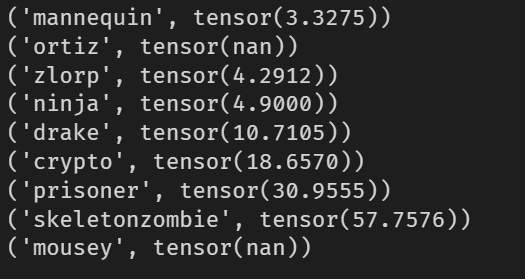

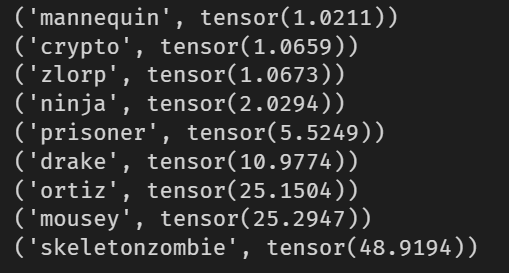

In [12]:
print(times_by_category)

In [18]:
os.path.join(data_root, 'off', '**.off')

In [ ]:
/home/s94zalek_hpc/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/data/DT4D_r/off/crypto/Punching015.off

In [12]:
import pymeshlab

ms = pymeshlab.MeshSet()

In [ ]:
import numpy as np

mesh_orig = trimesh.load(
    # '/home/s94zalek_hpc/shape_matching/data/DT4D_r/off/crypto/Punching019.off',
    # '/home/s94zalek_hpc/shape_matching/data/DT4D_r/off/ninja/BigSideHit009.off',
    # '/home/s94zalek_hpc/shape_matching/data/DT4D_r/off/skeletonzombie/GoalkeeperScoop000.off',
    # '/home/s94zalek_hpc/shape_matching/data/DT4D_r/off/prisoner/BboyUprockStart000.off',
    # '/home/s94zalek_hpc/shape_matching/data/DT4D_r/off/drake/InvertedDoubleKickToKipUp006.off'
    '/home/s94zalek_hpc/shape_matching/data/DT4D_r/off/ortiz/Flair002.off'
    # process=True, validate=True
                    )

mesh = pymeshlab.Mesh(mesh_orig.vertices, mesh_orig.faces)
ms.add_mesh(mesh)


# ms.meshing_isotropic_explicit_remeshing()
ms.meshing_repair_non_manifold_edges()
ms.meshing_close_holes(maxholesize=150, refinehole=True)

mesh_repaired = trimesh.Trimesh(ms.current_mesh().vertex_matrix(), ms.current_mesh().face_matrix())
mesh_repaired.vertices += np.array([1, 0, 0])

ms.clear()

scene.geometry.clear()
scene.add_geometry(mesh_orig)
scene.add_geometry(mesh_repaired)

light = trimesh.scene.lighting.DirectionalLight(color=[255, 255, 255, 255])
scene.lights = [light]

print(f'before: {mesh_orig.vertices.shape}')
print(f'after: {mesh_repaired.vertices.shape}')

scene.show()

# Compare with ULRSSM

In [13]:
log_file = '/home/s94zalek_hpc/Unsupervised-Learning-of-Robust-Spectral-Shape-Matching/results/dt4d_intra_class/log/test_dt4d_intra_class_20241029_122533.log'

with open(log_file, 'r') as f:
    lines = f.readlines()
    
len(lines)

In [15]:
categories = []

for file in single_dataset.off_files:
    categories.append(file.split('/')[-2])
    
categories = list(set(categories))
print(categories)

In [18]:
# filter all lines that have 'Val geo error: ' in them
err_by_category = {category: 0 for category in categories}
times_by_category = {category: 0 for category in categories}

for line in lines:
    if 'Val geo error: ' in line:
        
        # each line has form 2024-10-29 16:54:20,347 INFO: Val geo error: data/DT4D_r/off/zlorp/DancingRunningMan325.off-data/DT4D_r/off/zlorp/DancingRunningMan272.off, 1.0841
        # get two file names and the error
        
        file_names = line.split('Val geo error: ')[1].split(', ')[0]
        file_name_1, file_name_2 = file_names.split('-')
        
        category_1 = file_name_1.split('/')[-2]
        category_2 = file_name_2.split('/')[-2]
        
        error = float(line.split('Val geo error: ')[1].split(', ')[1])
        
        # print(file_names)
        # print(category_1, category_2, error)
        
        err_by_category[category_1] += error
        err_by_category[category_2] += error
        
        times_by_category[category_1] += 1
        times_by_category[category_2] += 1
        
for category in categories:
    err_by_category[category] /= times_by_category[category]
    
# convert to list of tuples
err_by_category = {(k, v) for k, v in err_by_category.items()}

err_by_category = sorted(err_by_category, key=lambda x: x[1], reverse=False)

for item in err_by_category:
    print(item)

In [19]:
print(times_by_category)

In [66]:
from diffusers import UNet2DModel

# 
#   sample_size: 64
#   in_channels: 3
#   out_channels: 1
#   layers_per_block: 2
#   block_out_channels: !!python/tuple
#   - 64
#   - 128
#   - 128
#   down_block_types: !!python/tuple
#   - DownBlock2D
#   - AttnDownBlock2D
#   - AttnDownBlock2D
#   up_block_types: !!python/tuple
#   - AttnUpBlock2D
#   - AttnUpBlock2D
#   - UpBlock2D

model_params = {
    'sample_size': 64,
    'in_channels': 3,
    'out_channels': 1,
    'layers_per_block': 2,
    'block_out_channels': (64, 128, 128),
    'down_block_types': ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    'up_block_types': ('AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D')
}


unet = UNet2DModel(
    **model_params
)

In [67]:
# get number of trainable parameters
sum(p.numel() for p in unet.parameters() if p.requires_grad)

In [68]:
import networks.diffusion_network as diffusion_network

#   net_params:
    # in_channels: 128
    # input_type: wks
    # k_eig: 128
    # n_block: 6
    # out_channels: 48
    
net_params = {
    'in_channels': 128,
    'input_type': 'wks',
    'k_eig': 128,
    'n_block': 6,
    'out_channels': 48
}


sign_corr_net = diffusion_network.DiffusionNet(
    **net_params
    )  

In [69]:
sum(p.numel() for p in sign_corr_net.parameters() if p.requires_grad)

In [70]:
import torch

tens = torch.randn(2, 4)
print(tens)
print(tens.tolist())

In [73]:
import yaml

data_to_save = [{
    'name': 'test',
    'data': tens.tolist()
},
                {
    'name': 'test2',
    'data': (tens * 2).tolist()
}]

# save to /home/s94zalek_hpc/shape_matching/notebooks/release/test.yaml
with open('/home/s94zalek_hpc/shape_matching/notebooks/release/test.yaml', 'w') as f:
    yaml.dump(data_to_save, f, sort_keys=False)

In [74]:
# read from file and print
with open('/home/s94zalek_hpc/shape_matching/notebooks/release/test.yaml', 'r') as f:
    data_loaded = yaml.load(f, Loader=yaml.FullLoader)
    
print(data_loaded)

In [86]:
# get size of this file in MegaBytes
# /home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/FAUST_r_pair-test/no_smoothing/2024-11-02_11-26-15/pairwise_results.yaml

import os

# os.path.getsize('/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/FAUST_r_pair-test/no_smoothing/2024-11-02_11-37-25/pairwise_results.yaml') / 1024 / 1024
os.path.getsize('/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/single_64_1-2ev_64-128-128_remeshed_fixed/eval/epoch_99/FAUST_r_pair-test/no_smoothing/2024-11-02_11-48-59/pairwise_results.json') / 1024 / 1024


In [81]:
import metrics.geodist_metric as geodist_metric

auc, pcks, thresholds = geodist_metric.plot_pck(
    [10, 20, 30], 
    threshold=0.10, steps=40, show_figure=False)

print(auc.item(), pcks.tolist(), thresholds.tolist())